# Puzzle Solver 🧩

In [12]:
# Don't worry about it it just used for easier coding:
import os
import glob
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Upload zip file
from google.colab import files
uploaded = files.upload()

In [13]:
# Extract the zip file
import zipfile
with zipfile.ZipFile("Puzzle_2_160.zip", 'r') as zip_ref:
    zip_ref.extractall("puzzle_data2")

In [14]:
# path of dataset change with your own path
folder_path = r"puzzle_data2/Puzzle_2_160"

In [15]:
#Read Images
output_file = os.path.join(folder_path, "Output.tif")
patch_files = glob.glob(os.path.join(folder_path, "Patch_*.tif"))

corners_img = np.array(Image.open(output_file))
# Get copy of image to edit it later
base_img = corners_img.copy()

patches = [np.array(Image.open(patch_file)) for patch_file in patch_files]

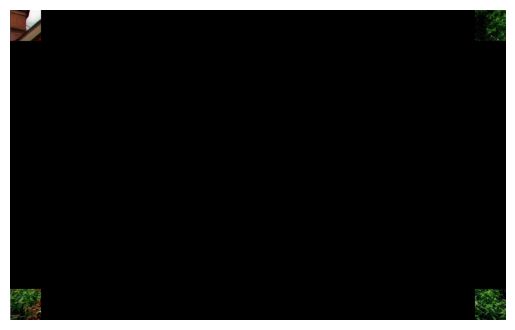

In [16]:
plt.imshow(base_img)
plt.axis('off')
plt.show()

In [17]:
class Tile:
    def __init__(self, id, image):
        self.id = id
        self.image = image
        self.edges = self.extract_edges()

    def extract_edges(self):
        return {
            'top': self.image[0, :, :],
            'bottom': self.image[-1, :, :],
            'left': self.image[:, 0, :],
            'right': self.image[:, -1, :]
        }

In [18]:
# Create a list of pieces
tiles = []
for i, patch_file in enumerate(patch_files):
    patch_img = np.array(Image.open(patch_file))
    tiles.append(Tile(i, patch_img))


In [19]:
# TODO:
# Now you should solve puzzle do it the best you can.
# Find the number of rows and columns
tile_h, tile_w, _ = patches[0].shape
rows, cols = 5, 8
puzzle_grid = [[None for _ in range(cols)] for _ in range(rows)]

# Separate the corners from the Output.tif
top_left_tile = corners_img[0:tile_h, 0:tile_w]
top_right_tile = corners_img[0:tile_h, -tile_w:]
bottom_left_tile = corners_img[-tile_h:, 0:tile_w]
bottom_right_tile = corners_img[-tile_h:, -tile_w:]

# Add corners to the list of pieces
corner_tiles = [
    Tile(-1, top_left_tile),
    Tile(-2, top_right_tile),
    Tile(-3, bottom_left_tile),
    Tile(-4, bottom_right_tile)
]
tiles.extend(corner_tiles)
used_indices = {-1, -2, -3, -4}

# Putting the corners in the right place
puzzle_grid[0][0] = corner_tiles[0]   # top left
puzzle_grid[0][-1] = corner_tiles[1]  # top right
puzzle_grid[-1][0] = corner_tiles[2]  # bottom left
puzzle_grid[-1][-1] = corner_tiles[3] # bottom right

In [20]:
# Improved function to compare two puzzle edges using HSV color space
def edge_difference(edge1, edge2):
    # Convert both edges from RGB to HSV (better for color comparison)
    hsv1 = cv2.cvtColor(edge1[None, :, :], cv2.COLOR_RGB2HSV)
    hsv2 = cv2.cvtColor(edge2[None, :, :], cv2.COLOR_RGB2HSV)

    # Calculate pixel-wise Euclidean distance in HSV space
    diff = np.linalg.norm(hsv1.astype(np.float32) - hsv2.astype(np.float32), axis=-1)

    # Return the average difference (smaller = more similar)
    return np.mean(diff)

In [21]:
# Function to find the best matching puzzle tile for a given position (i, j)
def find_best_tile(i, j, tiles, puzzle_grid, used_indices):
    # Initialize variables to track the best score and tile
    min_score = float('inf')
    best_tile = None

    # Loop through all available tiles
    for tile in tiles:
        # Skip tiles that are already placed
        if tile.id in used_indices:
            continue

        score = 0
        weight_count = 0

        # Define directions to check: (row_offset, col_offset, neighbor_edge, tile_edge)
        directions = [
            (-1, 0, 'bottom', 'top'),   # Check tile above
            (1, 0, 'top', 'bottom'),    # Check tile below
            (0, -1, 'right', 'left'),   # Check tile on the left
            (0, 1, 'left', 'right')     # Check tile on the right
        ]

        # Compare current tile's edges with any existing neighbors
        for di, dj, neighbor_edge, tile_edge in directions:
            ni, nj = i + di, j + dj
            if 0 <= ni < rows and 0 <= nj < cols and puzzle_grid[ni][nj] is not None:
                neighbor = puzzle_grid[ni][nj]
                score += edge_difference(neighbor.edges[neighbor_edge], tile.edges[tile_edge])
                weight_count += 1

        # Average the score if neighbors exist, otherwise set to infinity
        if weight_count > 0:
            score /= weight_count
        else:
            score = float('inf')

        # Keep the tile with the lowest (best) score
        if score < min_score:
            min_score = score
            best_tile = tile

    return best_tile

In [22]:
# Function to assemble the full image from the puzzle grid
def assemble_final_image(puzzle_grid):
    # Get height, width, and number of color channels from the first tile
    tile_h, tile_w, channels = puzzle_grid[0][0].image.shape

    # Create an empty (black) image for the final result
    final_img = np.zeros((rows * tile_h, cols * tile_w, channels), dtype=np.uint8)

    # Loop through each position in the puzzle grid
    for r in range(rows):
        for c in range(cols):
            tile = puzzle_grid[r][c]
            if tile is not None:
                # Place the tile's image in the correct position
                final_img[r*tile_h:(r+1)*tile_h, c*tile_w:(c+1)*tile_w, :] = tile.image
            else:
                # If no tile, fill the space with black
                final_img[r*tile_h:(r+1)*tile_h, c*tile_w:(c+1)*tile_w, :] = 0

    # Return the assembled final image
    return final_img

In [25]:
# TODO:
# Now you should solve puzzle do it the best you can.
# Puzzle solver function (uses a priority queue)
def puzzle_solver():
    global puzzle_grid, used_indices

    # Make a copy of the current grid and used tile indices
    local_grid = [[puzzle_grid[r][c] for c in range(cols)] for r in range(rows)]
    local_used = used_indices.copy()

    # Priority queue format: (-filled_neighbors_count, row, col)
    # Negative count is used because heapq pops the smallest number first,
    # but we want positions with the most neighbors to have higher priority
    pq = []

        # Function to count how many neighbors of a position are already filled
    def get_filled_neighbors(i, j):
        count = 0
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
        for di, dj in directions:
            ni, nj = i + di, j + dj
            if 0 <= ni < rows and 0 <= nj < cols and local_grid[ni][nj] is not None:
                count += 1
        return count

    # Get all empty positions in the grid
    positions_to_fill = set((i, j) for i in range(rows) for j in range(cols) if local_grid[i][j] is None)

    # Start from positions next to the corners
    initial_positions = [
        (0, 1), (1, 0),
        (0, cols - 2), (1, cols - 1),
        (rows - 2, 0), (rows - 1, 1),
        (rows - 2, cols - 1), (rows - 1, cols - 2)
    ]

    # Add valid initial positions to the priority queue
    for i, j in initial_positions:
        if (i, j) in positions_to_fill:
            heapq.heappush(pq, (-get_filled_neighbors(i, j), i, j))

    # Fill puzzle using the priority queue
    while pq:
        _, i, j = heapq.heappop(pq)
        if local_grid[i][j] is not None:
            continue

        # Find the best matching tile for this position
        best_tile = find_best_tile(i, j, tiles, local_grid, local_used)
        if best_tile:
            local_grid[i][j] = best_tile
            local_used.add(best_tile.id)

            # Add the new empty neighbors to the priority queue
            directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            for di, dj in directions:
                ni, nj = i + di, j + dj
                if 0 <= ni < rows and 0 <= nj < cols and local_grid[ni][nj] is None:
                    heapq.heappush(pq, (-get_filled_neighbors(ni, nj), ni, nj))

    # Assemble the final completed image
    final_img = assemble_final_image(local_grid)
    return final_img


In [26]:
# Test and Save final Image
import heapq
final_img = puzzle_solver()
Image.fromarray(final_img).save(os.path.join(folder_path, "final.tif"))

In [27]:
# Now it's time to find what's our final image good base on original image

# This properties are determined according to the dataset:
rows, cols = 5, 8
img_width, img_height = 1920, 1200
patch_width, patch_height = img_width // cols, img_height // rows

def accuracy_block_base(original_img, final_img, rows, cols):
    correct_blocks = 0
    total_blocks = rows * cols
    for row in range(rows):
        for col in range(cols):
            patch = final_img[row*patch_height:(row+1)*patch_height, col*patch_width:(col+1)*patch_width]
            original_patch = original_img[row*patch_height:(row+1)*patch_height, col*patch_width:(col+1)*patch_width]

            if np.array_equal(patch, original_patch):
                correct_blocks += 1

    return 100 * correct_blocks / total_blocks

original_img = np.array(Image.open(os.path.join(folder_path, "Original.tif")))
accuracy= accuracy_block_base(original_img, final_img, rows, cols)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 7.50%


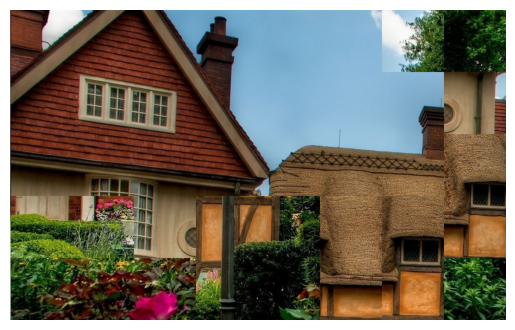

In [28]:
# show final_img - You can make animation for it while solving puzzle. That's fun!
plt.imshow(final_img)
plt.axis('off')
plt.show()

In [29]:
# Create animation video
video_path = "puzzle1_assembly.mp4"
frame_h = rows * tile_h
frame_w = cols * tile_w
current_frame = np.zeros((frame_h, frame_w, 3), dtype=np.uint8)
fps = 10
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(video_path, fourcc, fps, (frame_w, frame_h))

# Reset puzzle grid and mark corner IDs as used
used_indices.clear()
used_indices.update([-1, -2, -3, -4])
puzzle_grid = [[None for _ in range(cols)] for _ in range(rows)]

# Place the 4 corner tiles and record frames
corner_map = {
    (0, 0): -1,
    (0, cols-1): -2,
    (rows-1, 0): -3,
    (rows-1, cols-1): -4,
}
for (r, c), cid in corner_map.items():
    tile = next(t for t in tiles if t.id == cid)
    puzzle_grid[r][c] = tile
    current_frame[r*tile_h:(r+1)*tile_h, c*tile_w:(c+1)*tile_w, :] = tile.image
    video_writer.write(current_frame.copy())

# Priority queue setup for filling the rest of the puzzle
pq = []
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Count how many neighbors are already filled
def get_filled_neighbors(i, j):
    count = 0
    for di, dj in directions:
        ni, nj = i + di, j + dj
        if 0 <= ni < rows and 0 <= nj < cols and puzzle_grid[ni][nj] is not None:
            count += 1
    return count

# Initial positions next to the corners
initial_positions = [
    (0,1), (1,0),
    (0, cols-2), (1, cols-1),
    (rows-2, 0), (rows-1,1),
    (rows-2, cols-1), (rows-1, cols-2)
]
for i, j in initial_positions:
    if puzzle_grid[i][j] is None:
        heapq.heappush(pq, (-get_filled_neighbors(i, j), i, j))

# Fill the puzzle while saving frames to the video
while pq:
    _, i, j = heapq.heappop(pq)
    if puzzle_grid[i][j] is not None:
        continue
    best_tile = find_best_tile(i, j, tiles, puzzle_grid, used_indices)
    if best_tile:
        puzzle_grid[i][j] = best_tile
        used_indices.add(best_tile.id)
        current_frame[i*tile_h:(i+1)*tile_h, j*tile_w:(j+1)*tile_w, :] = best_tile.image
        video_writer.write(current_frame.copy())

        # Add empty neighbors to priority queue
        for di, dj in directions:
            ni, nj = i + di, j + dj
            if 0 <= ni < rows and 0 <= nj < cols and puzzle_grid[ni][nj] is None:
                heapq.heappush(pq, (-get_filled_neighbors(ni, nj), ni, nj))

# Save and close the video file
video_writer.release()
print(f"✅ The puzzle assembly video was successfully saved to the path {video_path}.")

# Download the video in Google Colab
from google.colab import files
files.download("puzzle1_assembly.mp4")


✅ The puzzle assembly video was successfully saved to the path puzzle1_assembly.mp4.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>